# Importing Fastai Vision

In [1]:
from fastai.vision import *
from fastai.metrics import error_rate , accuracy

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Importing Data

In [3]:
path = Path("../input/10-monkey-species")

In [4]:
path.ls()

[PosixPath('../input/10-monkey-species/monkey_labels.txt'),
 PosixPath('../input/10-monkey-species/training'),
 PosixPath('../input/10-monkey-species/validation')]

In [5]:
(path/'training/training').ls()

[PosixPath('../input/10-monkey-species/training/training/n5'),
 PosixPath('../input/10-monkey-species/training/training/n3'),
 PosixPath('../input/10-monkey-species/training/training/n6'),
 PosixPath('../input/10-monkey-species/training/training/n4'),
 PosixPath('../input/10-monkey-species/training/training/n2'),
 PosixPath('../input/10-monkey-species/training/training/n8'),
 PosixPath('../input/10-monkey-species/training/training/n0'),
 PosixPath('../input/10-monkey-species/training/training/n7'),
 PosixPath('../input/10-monkey-species/training/training/n9'),
 PosixPath('../input/10-monkey-species/training/training/n1')]

**Loading Data**

Lets see the documentaintion of ImageDataBunch.from_folder()

In [6]:
#doc(ImageDataBunch.from_folder)

In [7]:
data = ImageDataBunch.from_folder(path,train='training',valid='validation',ds_tfms=get_transforms(),
                      bs=64,size=224).normalize(imagenet_stats)


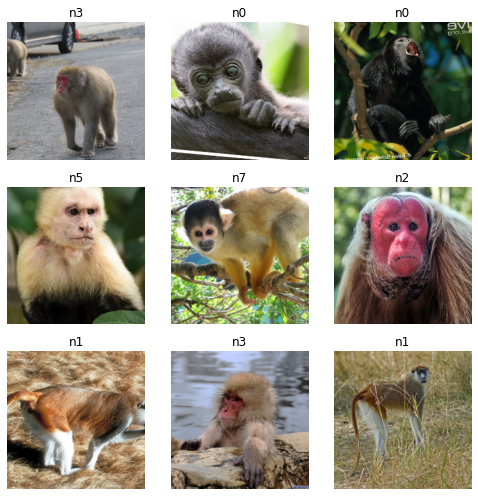

In [8]:
data.show_batch(rows=3,figsize=(7,7))

In [9]:
print(data.classes)
len(data.classes),data.c

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


(10, 10)

In [10]:
learn = cnn_learner(data,models.resnet34,metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Let's look out our model

In [11]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.699343,0.063303,0.018382,0.981618,01:02
1,0.806188,0.028697,0.003676,0.996324,01:01
2,0.476172,0.035471,0.011029,0.988971,01:01
3,0.311898,0.037056,0.014706,0.985294,01:00


****98% accuracy in just 4 epochs****

Let's save our model but before that we have change the directory to kaggle directory

In [13]:
learn.model_dir = '/kaggle/working'
learn.save('stage-1')

Let's see what are the top losses

In [14]:
#doc(ClassificationInterpretation.from_learner)

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

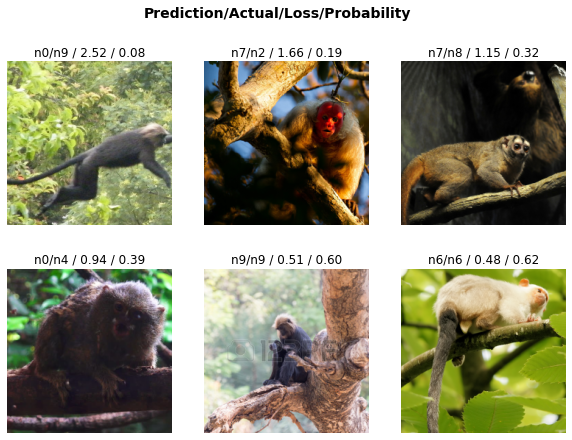

In [16]:
interp.plot_top_losses(6,figsize=(10,7))

**Let's check out the confusion matrix**

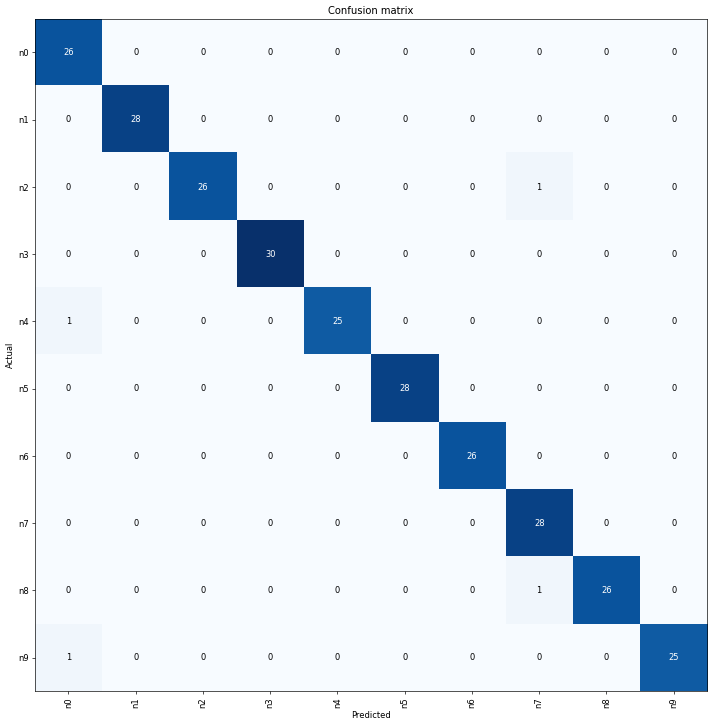

In [17]:
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

**Let's see where the model made the mistake**

In [18]:
interp.most_confused(min_val=2)

[]

In [19]:
interp.most_confused(min_val=3)

[]

Wow it seems our model has confused only two times between 'n0' and 'n9'

# Unfreeze, Fine-tuning and Learning Rate

What was actually happening is that we added a few layer on top of resnet34 layers and trained the model and so it was really fast and now let's unfreeze the model means 'please train the whole model' and run fit_one_cycle

In [20]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.169332,0.501793,0.102941,0.897059,01:01


Our accuracy decreased but soon we are gonna make it better. We have broke the model and so let's first bring back the earlier model

In [21]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (1097 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n5,n5,n5,n5,n5
Path: ../input/10-monkey-species;

Valid: LabelList (272 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n5,n5,n5,n5,n5
Path: ../input/10-monkey-species;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

**Learning rate finder**

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


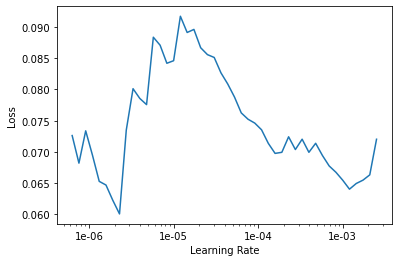

In [23]:
learn.recorder.plot()

In [24]:
#doc(learn.fit_one_cycle)

From the documentation we got to know that our learning rate is too high so we make small and also there is no sense in training the last layer of the model with same learning rate because the last layers were doing good

In [25]:
learn.unfreeze()
learn.fit_one_cycle(2,max_lr=slice(3e-4,1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.054766,0.087063,0.036765,0.963235,01:01
1,0.077344,0.049121,0.007353,0.992647,01:00


**Cool 99% accuracy**